<a href="https://colab.research.google.com/github/dcorredor20/water_demand_forecasting/blob/main/TCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/dcorredor20/water_demand_forecasting.git

  Cloning https://github.com/dcorredor20/water_demand_forecasting.git to /tmp/pip-req-build-u27lvti2
  Running command git clone -q https://github.com/dcorredor20/water_demand_forecasting.git /tmp/pip-req-build-u27lvti2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!ls gdrive 

Mounted at /content/gdrive
MyDrive


In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
from water_demand_forecasting import custom_plots
from water_demand_forecasting.wdf_model import WDF_Model
import tensorflow
import time
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Flatten, Dropout, Conv1D, Concatenate,BatchNormalization, ReLU, Add, ZeroPadding1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

In [41]:
# variables_model
VARIABLES = ["case_study"]
CONFIG = {
    "case_study":
      {"train": '/content/gdrive/MyDrive/DataThesis/DATI/Ferrara/Qh_CS3_14.txt',
      "test": '/content/gdrive/MyDrive/DataThesis/DATI/Ferrara/Qh_CS3_15.txt'},
      "days": 
      {"train": 'gdrive/MyDrive/DataThesis/Meteo/days2014.csv',
      "test": 'gdrive/MyDrive/DataThesis/Meteo/days2015.csv'},

    "precipitation":
      {"train": 'gdrive/MyDrive/DataThesis/Meteo/Prec2014CS2.csv',
      "test": 'gdrive/MyDrive/DataThesis/Meteo/Prec2015CS2.csv'},

    "relative_humidity":
      {"train": 'gdrive/MyDrive/DataThesis/Meteo/RH2014CS2.csv',
      "test": 'gdrive/MyDrive/DataThesis/Meteo/RH2015CS2.csv'},

    "temperature":
      {"train": 'gdrive/MyDrive/DataThesis/Meteo/MaxTem2014CS2.csv',
      "test": 'gdrive/MyDrive/DataThesis/Meteo/MaxTem2015CS2.csv'}} 
T = 168

In [42]:
Xtra, Ytra, Xval, Yval, Xtest, Ytest, scx, scy = WDF_Model.data_preprocessing(
    VARIABLES, CONFIG, lookback=T
)

In [43]:
earlyStopping= EarlyStopping(monitor='val_loss', patience=10, verbose=1,  min_delta=1e-4, mode='min')
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_delta=1e-3, mode='min')
callbacks = [earlyStopping, mcp_save, lr_reduced]

In [44]:
dilation_rates = (2**exp for exp in range(0, 5))
filter_size_block = 2
filter_size_branch = 1
number_filters = 32
dropout_rate = 0.2
outputs = 24
loss = 'mae'
metrics = 'mse'
epochs = 500
batch_size = 32
learning_rate = 0.0005

In [45]:
i = Input(shape=(T,len(VARIABLES)), name='Input layer')

x01 = ZeroPadding1D(padding=(filter_size_block-1,0))(i)

concatenated = x01
for d in dilation_rates:
  x1 = Conv1D(filters=number_filters, kernel_size=(filter_size_branch))(concatenated)

  x2 = Conv1D(number_filters, kernel_size=(filter_size_block), padding='causal', dilation_rate=d)(concatenated)
  x2 = BatchNormalization()(x2)
  x2 = ReLU()(x2)
  x2 = Dropout(rate=dropout_rate)(x2)
  concatenated = Add()([x2, x1])
   
x = Flatten()(concatenated)

x = Dense(units=outputs, activation='linear', name='Output')(x)

model = Model(i, x)
print(model.summary())

# compile the model
optimizer = Adam(learning_rate = learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input layer (InputLayer)        [(None, 168, 1)]     0                                            
__________________________________________________________________________________________________
zero_padding1d_3 (ZeroPadding1D (None, 169, 1)       0           Input layer[0][0]                
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 169, 32)      96          zero_padding1d_3[0][0]           
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 169, 32)      128         conv1d_31[0][0]                  
____________________________________________________________________________________________

In [46]:
start = time.time()
r = model.fit(Xtra, Ytra, verbose = 1, validation_data=(Xval, Yval), epochs=epochs, callbacks=callbacks, batch_size=batch_size)
end = time.time()
print('Total training time: ', end-start)

Epoch 1/500
201/201 [==============================] - 4s 13ms/step - loss: 0.8757 - mse: 1.3297 - val_loss: 0.2397 - val_mse: 0.0939
Epoch 2/500
201/201 [==============================] - 2s 10ms/step - loss: 0.4049 - mse: 0.2658 - val_loss: 0.1296 - val_mse: 0.0258
Epoch 3/500
201/201 [==============================] - 2s 10ms/step - loss: 0.2418 - mse: 0.0940 - val_loss: 0.0802 - val_mse: 0.0105
Epoch 4/500
201/201 [==============================] - 2s 10ms/step - loss: 0.1605 - mse: 0.0410 - val_loss: 0.0584 - val_mse: 0.0058
Epoch 5/500
201/201 [==============================] - 2s 10ms/step - loss: 0.1143 - mse: 0.0208 - val_loss: 0.0535 - val_mse: 0.0049
Epoch 6/500
201/201 [==============================] - 2s 11ms/step - loss: 0.0889 - mse: 0.0126 - val_loss: 0.0464 - val_mse: 0.0038
Epoch 7/500
201/201 [==============================] - 2s 10ms/step - loss: 0.0737 - mse: 0.0088 - val_loss: 0.0477 - val_mse: 0.0041
Epoch 8/500
201/201 [==============================] - 2s 10ms

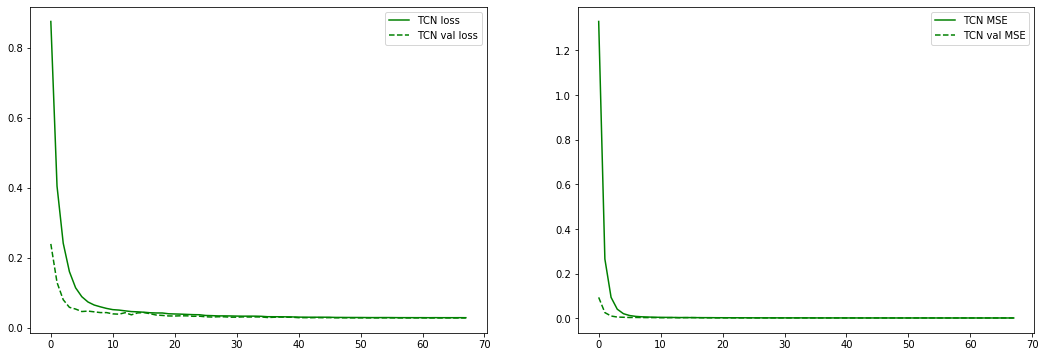

In [47]:
custom_plots.loss_plot(r, 'TCN', color = 'g')

In [48]:
model.load_weights('mdl_wts.hdf5')

In [49]:
def print_metrics(y,ypred,dataset):
  y = scy.inverse_transform(y) 
  ypred = scy.inverse_transform(ypred)
  print(f'{dataset}\t\tRMSE:{mean_squared_error(y,ypred)**0.5:.3f}\tMAE:{mean_absolute_error(y,ypred):.3f}\tR2:{r2_score(y,ypred):.3f}')

print_metrics(Ytra.reshape(-1,1),model.predict(Xtra).reshape(-1,1),'Train')
print_metrics(Yval.reshape(-1,1),model.predict(Xval).reshape(-1,1),'Val')
print_metrics(Ytest.reshape(-1,1),model.predict(Xtest).reshape(-1,1),'Test')

Train		RMSE:4.561	MAE:3.002	R2:0.971
Val		RMSE:4.895	MAE:3.284	R2:0.967
Test		RMSE:5.021	MAE:3.503	R2:0.963


In [50]:
Y_hatval = model.predict(Xval)
Y_val = scy.inverse_transform(Yval)
Yhatval = scy.inverse_transform(Y_hatval)
dat1y1 = pd.DataFrame(Y_val)
dat2y1 = pd.DataFrame(Yhatval)
e = 100*np.sum(np.abs((dat1y1 - dat2y1)/np.mean(dat1y1, axis = 0)), axis = 0)/len(dat1y1)
print(f'MAE% Y1 = {e.mean()}')

MAE% Y1 = 3.279027073264569


In [51]:
Y_hat = model.predict(Xtest)
Y_test = scy.inverse_transform(Ytest)
Yhat = scy.inverse_transform(Y_hat)
dat1y2 = pd.DataFrame(Y_test)
dat2y2 = pd.DataFrame(Yhat)
e = 100*np.sum(np.abs((dat1y2 - dat2y2)/np.mean(dat1y2, axis = 0)), axis = 0)/len(dat1y2)
print(f'MAE% Y2 = {e.mean()}')

MAE% Y2 = 3.6505722436373875
